# November 22th, 2021 (corr distributions)

**Motivation**: Visualizing distribution of correlations and discussing different sparsification approaches <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def show_corrs(key):
    try:
        net_ca = Network(mice, key, 'ca2').load_network()
        net_bold = Network(mice, key, 'bold-lite').load_network()
    except TypeError:
        return 
    
    fig, axes = create_figure(2, 4, (12.8, 6))

    for i, _net in enumerate([net_bold, net_ca]):
        xl = _net.adj[_net.l_ids][:, _net.l_ids]
        xr = _net.adj[_net.r_ids][:, _net.r_ids]
        vmin = np.min(_net.adj)
        vmax = np.max(_net.adj)

        j = 2 * i
        im = axes[0, j].imshow(xl, vmin=vmin, vmax=vmax, cmap='Spectral_r')
        plt.colorbar(im, ax=axes[0, j], shrink=0.75)
        axes[0, j].set_title(f"{_net.mode} (left hemis)")

        j = 2 * i + 1
        im = axes[0, j].imshow(xr, vmin=vmin, vmax=vmax, cmap='Spectral_r')
        plt.colorbar(im, ax=axes[0, j], shrink=0.75)
        axes[0, j].set_title(f"{_net.mode} (right hemis)")

        j = 2 * i
        sns.histplot(
            data=xl[xl.nonzero()],
            label='left hemis',
            stat='percent',
            color='C0',
            bins=30,
            alpha=0.7,
            ax=axes[1, j],
        )
        sns.histplot(
            data=xr[xr.nonzero()],
            label='right hemis',
            stat='percent',
            color='C3',
            bins=30,
            alpha=0.7,
            ax=axes[1, j],
        )
        axes[1, j].set_xlabel('correlation')
        axes[1, j].set_title(f"{_net.mode} corr hist")
        axes[1, j].legend()

        j = 2 * i + 1
        sns.ecdfplot(
            data=xl[xl.nonzero()],
            label='left hemis',
            color='C0',
            lw=2,
            ax=axes[1, j],
        )
        sns.ecdfplot(
            data=xr[xr.nonzero()],
            label='right hemis',
            color='C3',
            lw=2,
            ax=axes[1, j],
        )
        axes[1, j].set_xlabel('correlation')
        axes[1, j].set_title(f"{_net.mode} corr ecdf")
        axes[1, j].legend()
        axes[1, j].grid()
    fig.suptitle(key, fontsize=15, y=1.03)
    plt.show()
    
    return (net_ca, net_bold), (fig, axes)

In [3]:
mice = Mice((100, 3))

In [4]:
in_house = '/home/hadi/Documents/Ca-fMRI/Yale/atlases_templates'
in_house = pjoin(in_house, 'Symmetric_N162_0.20.nii.gz')
in_house = ants.image_read(in_house)
mask = in_house.get_mask().numpy()

in_house

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (60, 46, 81)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [5]:
m_l = np.zeros_like(mask)
m_r = np.zeros_like(mask)
m_l[:30] = 1
m_r[30:] = 1

m_l *= mask
m_r *= mask

In [6]:
id2vox = {i + 1: vox for i, vox in enumerate(zip(*np.where(mask)))}
vox2id = {vox: idx for idx, vox in id2vox.items()}

voxels_l = [vox2id[vox] for vox in zip(*np.where(m_l))]
voxels_r = [vox2id[vox] for vox in zip(*np.where(m_r))]

l_ids = np.where(np.isin(list(id2vox), voxels_l))[0]
r_ids = np.where(np.isin(list(id2vox), voxels_r))[0]
assert not set(l_ids).intersection(r_ids)

len(id2vox), len(voxels_l), len(voxels_r), len(l_ids), len(r_ids)

(53520, 26760, 26760, 26760, 26760)

In [8]:
keys = [
    'sub-SLC01_ses-1_run-5',
    'sub-SLC01_ses-1_run-7',
    'sub-SLC01_ses-3_run-7',
    'sub-SLC02_ses-1_run-1',
    'sub-SLC02_ses-2_run-1',
    'sub-SLC02_ses-2_run-3',
    'sub-SLC02_ses-2_run-5',
    'sub-SLC02_ses-3_run-5',
    'sub-SLC03_ses-3_run-5',
    'sub-SLC03_ses-3_run-7',
    'sub-SLC04_ses-3_run-7',
    'sub-SLC07_ses-3_run-5',
]

In [13]:
%%time

for key in tqdm(keys):
    file = next(
        f for f in os.listdir(mice.cfg.npy_dir)
        if all(e in f for e in [key, 'N162'])
    )
    x = np.load(pjoin(mice.cfg.npy_dir, file))
    x *= np.expand_dims(mask, -1)
    data = {idx: x[vox] for idx, vox in id2vox.items()}
    data = pd.DataFrame(data)

    a, p = get_adj_mat(data, 'pearson')
    _ = save_obj(a, f'adj_{key}', tmp_dir, 'npy')

  0%|          | 0/12 [00:00<?, ?it/s]

[PROGRESS] 'adj_sub-SLC01_ses-1_run-5.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

[PROGRESS] 'adj_sub-SLC01_ses-1_run-7.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

[PROGRESS] 'adj_sub-SLC01_ses-3_run-7.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

[PROGRESS] 'adj_sub-SLC02_ses-1_run-1.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

[PROGRESS] 'adj_sub-SLC02_ses-2_run-1.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

[PROGRESS] 'adj_sub-SLC02_ses-2_run-3.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

[PROGRESS] 'adj_sub-SLC02_ses-2_run-5.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

[PROGRESS] 'adj_sub-SLC02_ses-3_run-5.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

[PROGRESS] 'adj_sub-SLC03_ses-3_run-5.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

[PROGRESS] 'adj_sub-SLC03_ses-3_run-7.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

[PROGRESS] 'adj_sub-SLC04_ses-3_run-7.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

[PROGRESS] 'adj_sub-SLC07_ses-3_run-5.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

CPU times: user 7h 30min 34s, sys: 3h 42min 18s, total: 11h 12min 53s
Wall time: 16h 21min 55s


In [7]:
import gc

gc.collect()

61

In [8]:
keys = [
    'sub-SLC03_ses-3_run-5',
    'sub-SLC03_ses-3_run-7',
    'sub-SLC04_ses-3_run-7',
    'sub-SLC07_ses-3_run-5',
]

In [ ]:
%%time

for key in tqdm(keys):
    a = f"adj_{key}.npy"
    a = pjoin(tmp_dir, a)
    a = np.load(a, mmap_mode='r')
    
    a_l = a[l_ids][:, l_ids]
    a_r = a[r_ids][:, r_ids]

    a_l = a_l[a_l.nonzero()]
    a_r = a_r[a_r.nonzero()]
    
    print(key)
    
    fig, axes = create_figure(1, 2, (8, 3.6), sharex='all')

    sns.histplot(a_l, label='left hemis', color='C0', stat='percent', alpha=0.5, ax=axes[0])
    sns.histplot(a_r, label='right hemis', color='C3', stat='percent', alpha=0.5, ax=axes[0])
    axes[0].legend()

    sns.ecdfplot(a_l, label='left hemis', color='C0', lw=2, ax=axes[1])
    sns.ecdfplot(a_r, label='right hemis', color='C3', lw=2, ax=axes[1])
    axes[1].legend()
    axes[1].grid()
    sup = fig.suptitle(key, y=1.03, fontsize=15)
    fig.savefig(pjoin(tmp_dir, f"left_right_dist_ecdf_{key}.png"), dpi=70)
    plt.show()
    
    del a
    del a_l
    del a_r
    gc.collect()
    
    print('-' * 80)
    print('\n\n')
    

  0%|          | 0/5 [00:00<?, ?it/s]

sub-SLC02_ses-3_run-5

In [8]:
a = 'adj_sub-SLC01_ses-1_run-5.npy'
a = pjoin(tmp_dir, a)
a = np.load(a, mmap_mode='r')

In [9]:
a_l = a[l_ids][:, l_ids]
a_r = a[r_ids][:, r_ids]

a_l = a_l[a_l.nonzero()]
a_r = a_r[a_r.nonzero()]

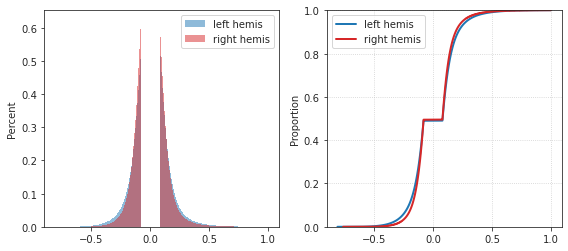

In [13]:
key = 'SLC01_ses-1_run-5'

Text(0.5, 1.03, 'SLC01_ses-1_run-5')

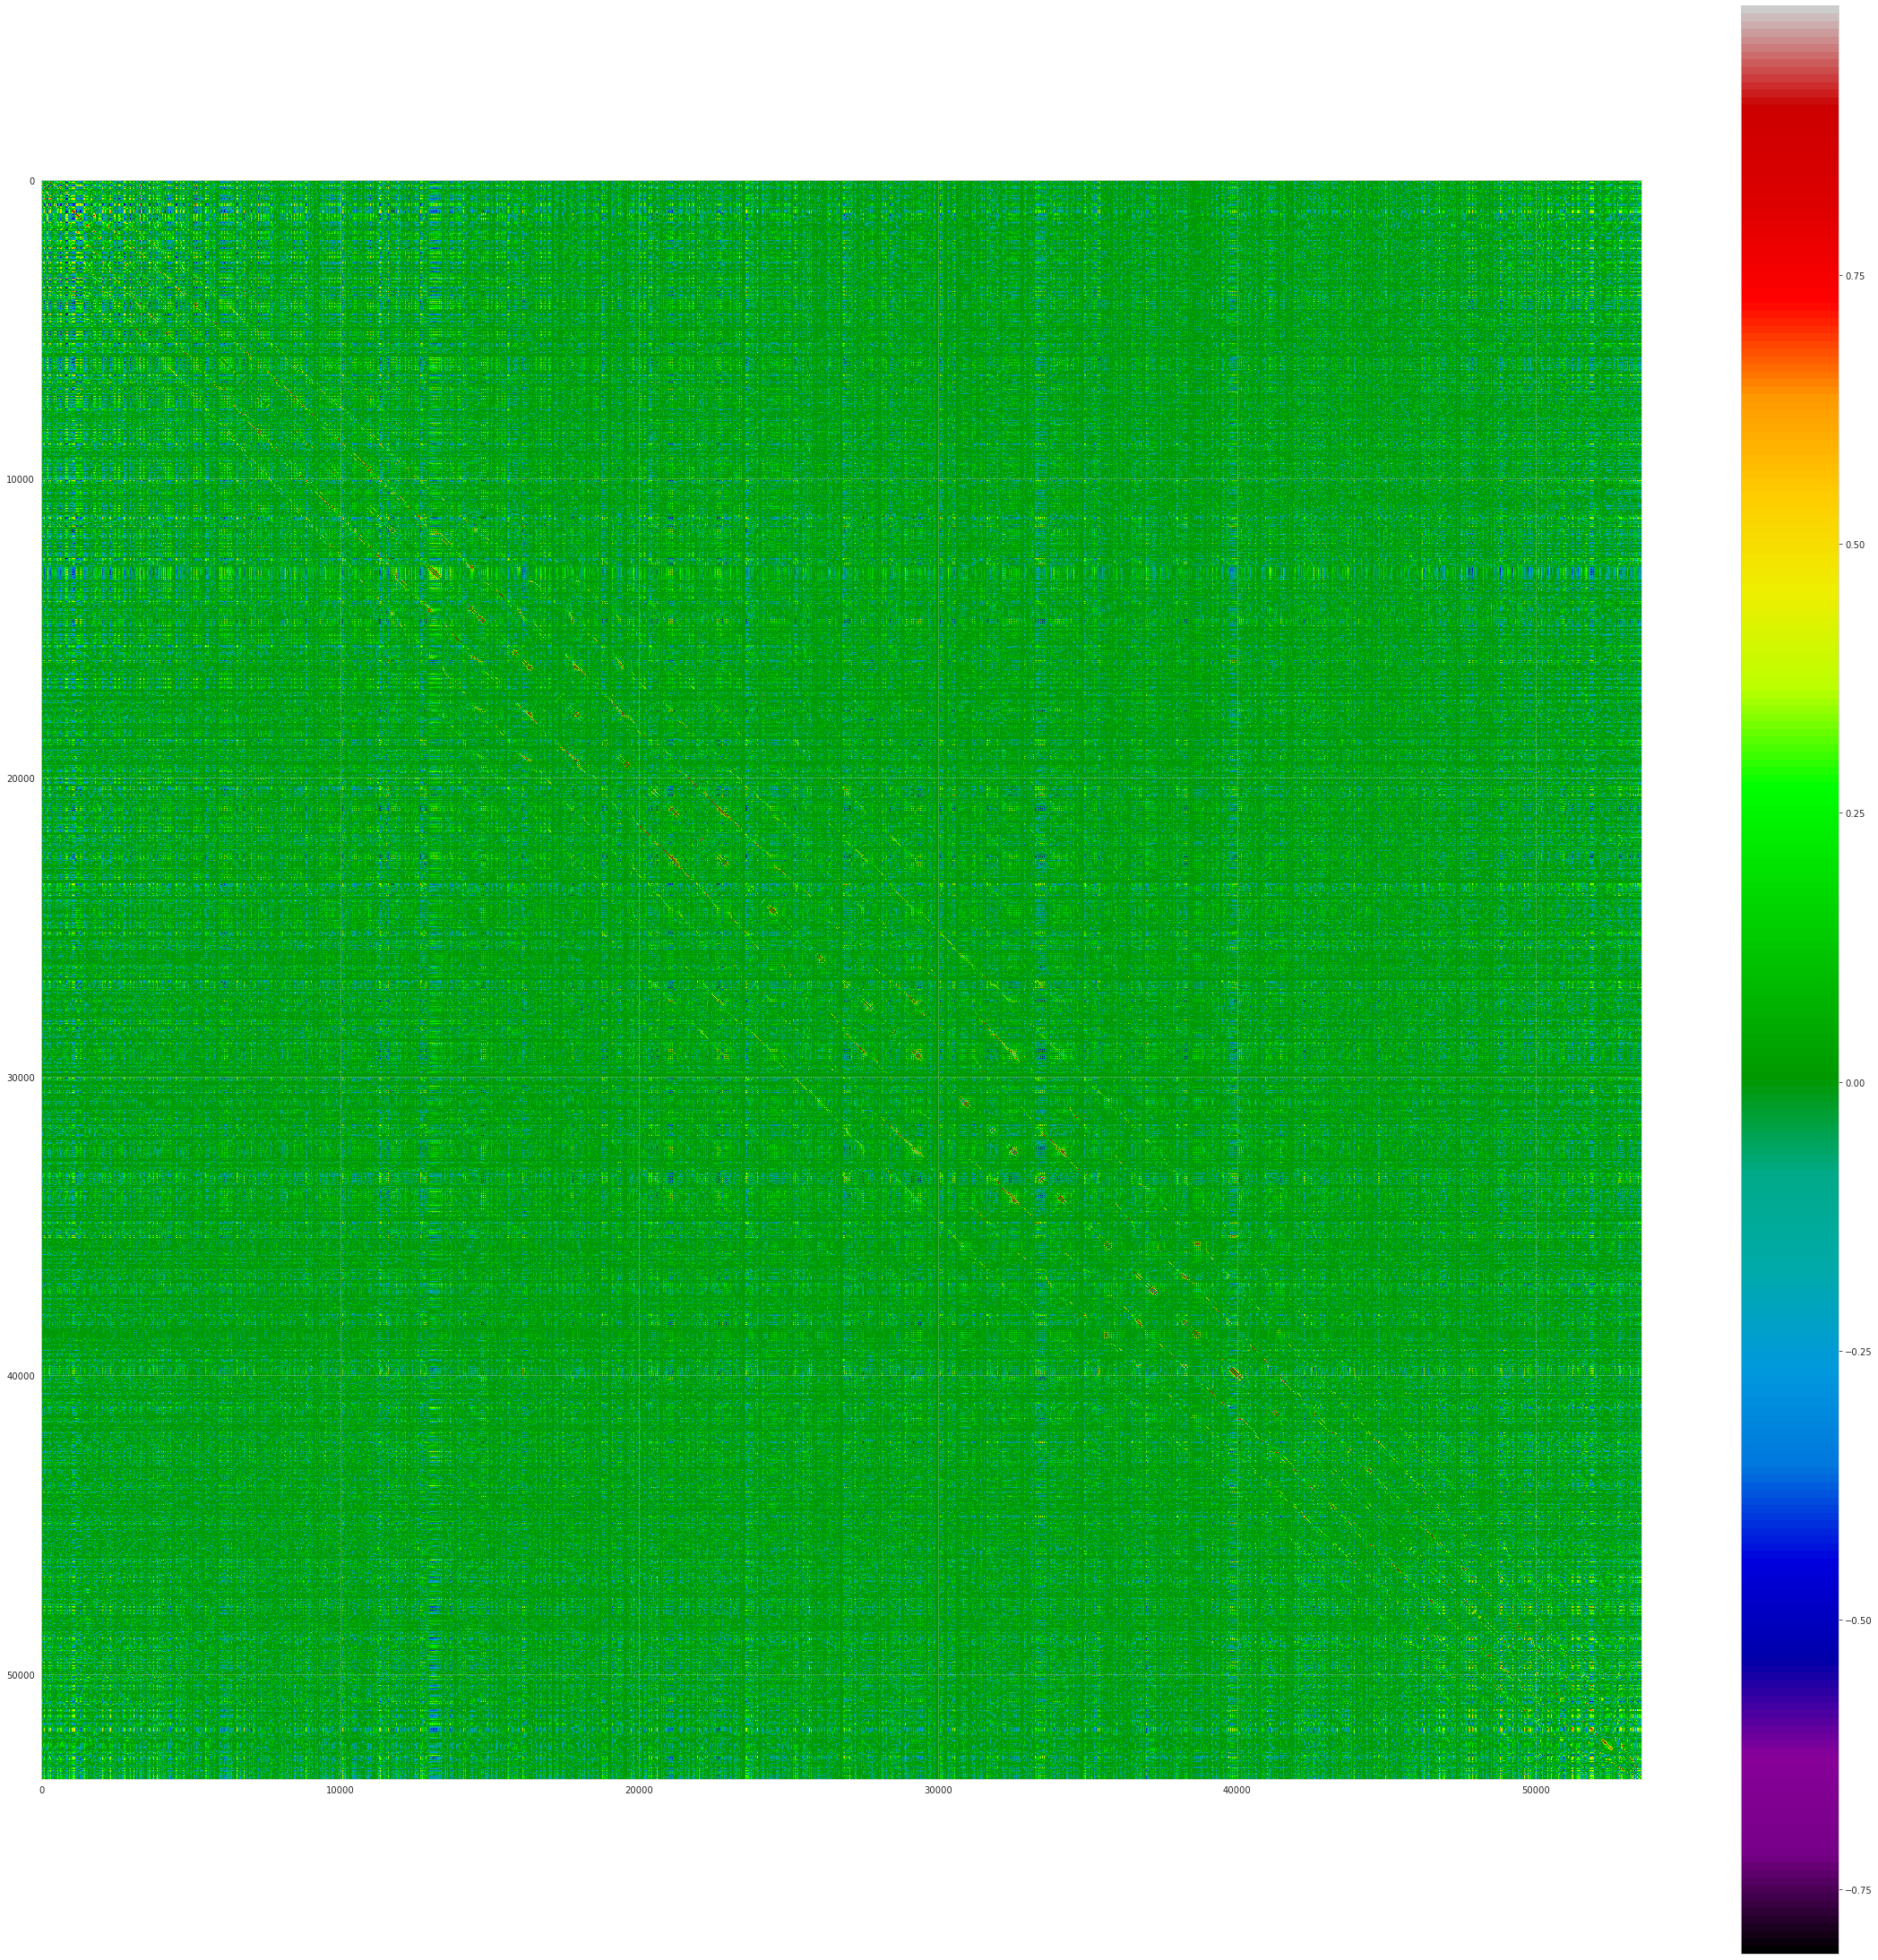

In [27]:
plt.figure(figsize=(40, 40))
plt.imshow(a, cmap='nipy_spectral')
plt.colorbar()
plt.show()

In [33]:
from analysis.hierarchical import sp_hier

In [37]:
d = (1 - a) / 2
np.fill_diagonal(d, 0.)

In [ ]:
%%time

linkage = sp_hier.linkage(
    sp_dist.squareform(d),
    method='ward',
    metric='correlation',
    optimal_ordering=True,
)

In [ ]:
%%time

hier_result = get_clust_graph(
    linkage_mat=linkage,
    labels=list(id2vox),
    num_clusters=5,
)